In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import librosa

import os, re, string

from recording import Recording

from collections import Counter

In [2]:
wav_path = './EmoDB/wav/'
laut_path = './EmoDB/lablaut/'
data_available = sorted([s.split('.')[0] for s in os.listdir(wav_path) if s.endswith('.wav')])

training_sample_ids = [s for s in data_available if s[:2] not in ['15','16']]

df = pd.DataFrame()
valid_phonemes = list(''.join([string.ascii_letters,string.digits,'@']))

for x in tqdm(data_available):
    rec = Recording(x)

    tmp = rec.df_tags
    tmp = tmp[tmp.phoneme.isin(valid_phonemes)]
    
    for i,row in tmp.iterrows():
        mfcc_cepstrum = rec.get_mfcc(row.t_start,row.t_stop)
        if mfcc_cepstrum.shape[1] > 0:
            df = df.append({
                'phoneme': row.phoneme,
                'ID': x,
                'mfcc': np.mean(mfcc_cepstrum,axis=1)
            },ignore_index=True)

100%|██████████| 535/535 [01:54<00:00,  4.57it/s]


In [3]:
speaker_info = {'03': ('m', 31), '08': ('f', 34), '09': ('f', 21), '10': ('m', 32), '11': ('m', 26),
                '12': ('m', 30), '13': ('f', 32), '14': ('f', 35), '15': ('m', 25), '16': ('f', 31)}
emotion_map = {'A': 'fear', 'E': 'disgust', 'W': 'anger', 'L': 'boredom', 
               'F': 'happiness', 'N': 'neutral', 'T': 'sadness'}

df['sex'] = df.ID.apply(lambda x: speaker_info[x[:2]][0])
df['speaker_id'] = df.ID.apply(lambda x: x[:2])
df['age'] = df.ID.apply(lambda x: speaker_info[x[:2]][1])
df['emotion'] = df.ID.apply(lambda x: emotion_map[x[5]])
df.head()

,ID,mfcc,phoneme,sex,speaker_id,age,emotion
0,03a01Fa,"[-183.0098232051797, 168.33306788329978, -62.9...",l,m,03,31,happiness
1,03a01Fa,"[-332.60470336178, 140.3105308620342, 11.43617...",a,m,03,31,happiness
2,03a01Fa,"[-132.92774565847444, 185.69100900847153, -83....",p,m,03,31,happiness
3,03a01Fa,"[-166.9318088619976, 167.3315514018902, -74.15...",m,m,03,31,happiness
4,03a01Fa,"[-450.7110571537433, 100.90943824982259, 11.16...",l,m,03,31,happiness


In [66]:
Counter(df.phoneme.tolist()).most_common(20)

[('I', 1643),
 ('n', 1548),
 ('a', 1487),
 ('t', 1265),
 ('m', 913),
 ('s', 864),
 ('d', 755),
 ('v', 638),
 ('i', 528),
 ('g', 482),
 ('b', 473),
 ('l', 441),
 ('e', 437),
 ('N', 405),
 ('z', 397),
 ('@', 378),
 ('U', 322),
 ('E', 312),
 ('p', 305),
 ('f', 301)]

In [100]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score

phoneme = 'i'
df_ph = df#[df.phoneme == phoneme]
# df_ph = df_ph[df_ph.speaker_id == '03']

scaler = StandardScaler()
X = np.stack(df_ph.mfcc.tolist())
X = scaler.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X,df_ph.emotion.values)

lr = MLPClassifier(hidden_layer_sizes=(100,30),max_iter=2000,solver='lbfgs')
lr.fit(X_train, y_train)
np.mean(cross_val_score(lr,X,df_ph.emotion.values,cv=4))

KeyboardInterrupt: 

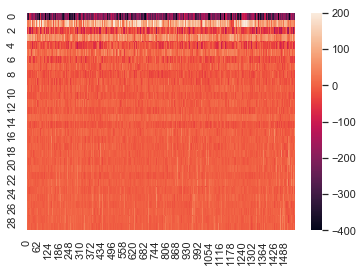

In [58]:
stack = np.stack(df[df.phoneme == 'n'].mfcc.tolist()).T
sns.heatmap(stack,vmin=-400,vmax=200)